In [1]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

In [2]:
#run this to update pyscf if you've modified it and dont want to restart the notebook
py"""
wd = os.getcwd()
sys.path.append(wd+'/../subroutines/')
import importlib
importlib.reload(RunPySCF)
"""

In [3]:
function h3_xyz(bl)
    
    a = """
    3
    charge=+1
    H $(bl) 0.0 0.0 
    H -$(bl) 0.0 0.0 
    H 0.0 0.0 0.0
    """
    
    fpath = "../configs/xyz_files/h3_stretch/$(bl).xyz"

    write(fpath, a)
    
end

h3_xyz (generic function with 1 method)

In [4]:
bond_lengths = [0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00,1.05,1.10,1.15,1.20,1.25,1.30,1.35,1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,1.95,2.00];

In [11]:
for bl in bond_lengths
    h3_xyz(bl)
end

In [5]:
# Generate some chemical data using RunPySCF
# Do this based on the parameters set in a .ini config file. 

py"""

config = configparser.ConfigParser()
config.read(wd+'/../configs/pyscf_configs/h3_stretch.ini')
RunPySCF.RunPySCF(config, nosec=True)

"""

UHF solution is stable.
index occupancies
[0, 1]
[0]
Running UHF FCI
../configs/xyz_files/h3_stretch/0.5.xyz
converged SCF energy = -0.932185700718717  <S^2> = 6.6613381e-16  2S+1 = 1

WARN: Not enough eigenvectors (len(x0)=2, nroots=3)

<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis
UHF solution is stable.
index occupancies
[0]
[0]
Running UHF FCI
-0.9480894264548541
E(UMP2) = -0.943518878682163  E_corr = -0.011333177963446
E(SCS-UMP2) = -0.945785514274852  E_corr = -0.0135998135561351
../configs/xyz_files/h3_stretch/0.55.xyz
converged SCF energy = -1.03010218166243  <S^2> = 6.6613381e-16  2S+1 = 1

WARN: Not enough eigenvectors (len(x0)=2, nroots=3)

<class 'pyscf.soscf.newton_ah.SecondOrderUHF'> wavefunction is stable in the internal stability analysis
UHF solution is stable.
index occupancies
[0]
[0]
Running UHF FCI
-1.0476681472657843
E(UMP2) = -1.04246922766562  E_corr = -0.0123670460031967
E(SCS-UMP2) = -1.04494263686626 

In [7]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)
#MAKE SURE TO UPDATE WHICH FILE YOU ARE READING IN IF YOU RUN THE ABOVE CELL

bond_lengths = [i/20 for i=10:40]

#  key   = system_basis_date%time.hdf5
md_fname = "h3_sto3g_072225%1013.hdf5"

chemical_data_list = ReadIn("../datasets/pyscf_data/"*md_fname, uhf=true)

PrintChemData(chemical_data_list[10])

Molecule name: h3
Basis set: sto3g
Molecular geometry: ../configs/xyz_files/h3_stretch/0.95.xyz
XHF energy: -1.1977409252603208
FCI energy: -1.2312893081388787


In [4]:

# Some global parameters:
#zeta_list = [0.03, 0.38, 0.48, 0.4, 0.34, 0.34, 0.29]
zeta_list = [0.29, 0.26, 0.3, 0.4, 0.3, 0.2]
weight_factor = 0.9
baseline = [0.1, 0.5]

# Standardized sweep objects:
opt_sweeps8 = Sweeps(20)
maxdim!(opt_sweeps8,8)
mindim!(opt_sweeps8,8)
cutoff!(opt_sweeps8,1e-12)
setnoise!(opt_sweeps8, 1e-1,1e-1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-12,0.0)

opt_sweeps3 = Sweeps(20)
maxdim!(opt_sweeps3,3)
mindim!(opt_sweeps3,3)
cutoff!(opt_sweeps3,1e-12)
setnoise!(opt_sweeps3, 1e-1,1e-1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-12,0.0)

"""
noisy_sweeps3 = Sweeps(6)
maxdim!(noisy_sweeps3,3)
mindim!(noisy_sweeps3,3)
cutoff!(noisy_sweeps3,1e-12)
setnoise!(noisy_sweeps3, 1e-1,1e-1,1e-1,1e-2,1e-3)
"""

# Geometry heuristic parameters:
# Single-geometry cost function parameters:
gp0 = GeomParameters(
    #costfunc = "simple",
    #zeta_list = [zeta_list[1]],
    maxiter = 2000,
)

"""
# Multi-geometry cost function parameters:
gp1 = GeomParameters(
    costfunc = "composite",
    zeta_list = zeta_list,
    wt = weight_factor,
    baseline = baseline,
    maxpop = 64,
    a_maxiter = 2000
)
"""

# Optimization parameters:
# A little pre-optimization:
op0 = OptimParameters(
    maxiter=1, 
    numloop=30, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="exp",
    alpha=2e4,
    restrict_svals=false,
    sweep=false,
    rnum=0,
    delta=5e-6,
    move_type="none",
    permute_states=false
)

# "Quantum" optimization paramers \\
# ... (make geometry moves)
op1q = OptimParameters(
    maxiter=30, 
    numloop=18, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="exp",
    alpha=2e4,
    restrict_svals=false,
    sweep=true,
    rnoise=1e-3,
    rswp=2,
    rnum=1,
    tethering=false,
    delta=1e-5,
    move_type="none",
    swap_num=-1,
    swap_mult=0.3,
    permute_states=true
)

# "Classial" optimization paramers \\
# ... (no geometry moves)
op1c = OptimParameters(
    maxiter=30, 
    numloop=18, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="exp",
    alpha=2e4,
    restrict_svals=false,
    tethering=false,
    sweep=true,
    rnoise=1e-3,
    rnum=1,
    rswp=2,
    delta=1e-5,
    move_type="none"
)

# Finishing touches:
op2 = OptimParameters(
    maxiter=1, 
    numloop=18, 
    noise=[1e-6], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="step",
    restrict_svals=true,
    sweep=true,
    delta=0.0,
    rnum=0,
    move_type="none"
);

MethodError: MethodError: no method matching OptimParameters(; maxiter::Int64, numloop::Int64, noise::Vector{Float64}, sd_thresh::String, sd_eps::Float64, afunc::String, alpha::Float64, restrict_svals::Bool, sweep::Bool, rnum::Int64, delta::Float64, move_type::String, permute_states::Bool)
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  OptimParameters(!Matched::OptimParameters; kws...)
   @ Main ~/.julia/packages/Parameters/MK0O4/src/Parameters.jl:569
  OptimParameters(!Matched::OptimParameters, !Matched::Tuple{Symbol, Any}...) got unsupported keyword arguments "maxiter", "numloop", "noise", "sd_thresh", "sd_eps", "afunc", "alpha", "restrict_svals", "sweep", "rnum", "delta", "move_type", "permute_states"
   @ Main ~/.julia/packages/Parameters/MK0O4/src/Parameters.jl:573
  OptimParameters(!Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any) got unsupported keyword arguments "maxiter", "numloop", "noise", "sd_thresh", "sd_eps", "afunc", "alpha", "restrict_svals", "sweep", "rnum", "delta", "move_type", "permute_states"
   @ Main ~/.julia/packages/Parameters/MK0O4/src/Parameters.jl:505
  ...


In [ ]:
# Standardized sweep objects:
opt_sweeps20 = Sweeps(40)
maxdim!(opt_sweeps20,20)
mindim!(opt_sweeps20,20)
cutoff!(opt_sweeps20,1e-12)
setnoise!(opt_sweeps20, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

opt_sweeps10 = Sweeps(40)
maxdim!(opt_sweeps10,10)
mindim!(opt_sweeps10,10)
cutoff!(opt_sweeps10,1e-12)
setnoise!(opt_sweeps10, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

opt_sweeps4 = Sweeps(40)
maxdim!(opt_sweeps4,4)
mindim!(opt_sweeps4,4)
cutoff!(opt_sweeps4,1e-12)
setnoise!(opt_sweeps4, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

# Geometry optimization parameters:
gp0 = GeomParameters(
    a_maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=1e1
)

# Number of MultiGeomOptim repetitions:
#nreps = 4

op0 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    sd_dtol=1e-4,
    delta=[1e-1],
    ttol=10.0
)

op1 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    sd_dtol=1e-4,
    delta=[0.0],
    ttol=10.0,
    sd_method="triple_geneig",
    sd_maxiter=2000,
    sd_penalty=1.0-1e-5
);

In [ ]:
# Parameter testing:

zeta_list = [0.29, 0.26, 0.3, 0.4, 0.3, 0.2]
weight_factor = 0.9

dmrg1p8 = GenSubspace(chemical_data_list[1], 6, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));
dmrg3p0 = GenSubspace(chemical_data_list[7], 6, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));

dmrg1p8.ord_list = [collect(1:dmrg1p8.chem_data.N_spt) for j=1:dmrg1p8.mparams.M]
dmrg3p0.ord_list = [collect(1:dmrg3p0.chem_data.N_spt) for j=1:dmrg3p0.mparams.M]

GenStates!(dmrg1p8, verbose=true, ovlp_opt=true, weight=1.0);
GenStates!(dmrg3p0, verbose=true, ovlp_opt=true, weight=1.0);

GenPermOps!(dmrg1p8, compute_alternates=false)
GenPermOps!(dmrg3p0, compute_alternates=false)

GenSubspaceMats!(dmrg1p8, verbose=true)
GenSubspaceMats!(dmrg3p0, verbose=true)

biparts1p8 = []
entrops1p8 = []
for j=1:dmrg1p8.mparams.M
    biparts_j, entrops_j = ComputeBipartites(dmrg1p8, state=j)
    push!(biparts1p8, biparts_j)
    push!(entrops1p8, entrops_j)
end

biparts3p0 = []
entrops3p0 = []
for j=1:dmrg3p0.mparams.M
    biparts_j, entrops_j = ComputeBipartites(dmrg3p0, state=j)
    push!(biparts3p0, biparts_j)
    push!(entrops3p0, entrops_j)
end

for j=1:dmrg1p8.mparams.M
    
    ord_list_j = BipartiteGenetics(
        1, 
        dmrg1p8.chem_data.N_spt, 
        biparts1p8[j], 
        entrops1p8[j], 
        dmrg1p8.mparams.psi_maxdim; 
        maxiter=20, 
        maxpop=100, 
        alpha=1.0, 
        beta=0.5, 
        gamma=0.05, 
        delta=0.1,
        zeta = zeta_list[j], 
        xi=0.3, 
        shufl=false, 
        verbose=true
    )
    
    dmrg1p8.ord_list[j] = ord_list_j[1]
    
    println("")
    
end

println("\n\n")

for j=1:dmrg3p0.mparams.M
    
    ord_list_j = BipartiteGenetics(
        1, 
        dmrg3p0.chem_data.N_spt, 
        biparts3p0[j], 
        entrops3p0[j], 
        dmrg3p0.mparams.psi_maxdim; 
        maxiter=20, 
        maxpop=100, 
        alpha=1.0, 
        beta=0.5, 
        gamma=0.05, 
        delta=0.1,
        zeta = zeta_list[j], 
        xi=0.3, 
        shufl=false, 
        verbose=true
    )
    
    dmrg3p0.ord_list[j] = ord_list_j[1]
    
    println("")
    
end

"""
for j=1:tnqe1.mparams.M
    println(BipartiteFitness([tnqe1.ord_list[j]], biparts[j], entrops[j], tnqe1.mparams.psi_maxdim; zeta=zeta_list[j]))
end
"""



In [ ]:
##### Collect the various estimates:

e_dmrg10_vec = []
e_dmrg4_vec = []
e_nomps_vec = []
e_tnqe_vec = []
Ipq_vec = []

# Repeat for each geometry:
for m0=4:4
    
    m = 4*m0
    
    cdata = chemical_data_list[m]
    
    println("\n\n##### MOLECULAR GEOMETRY $(m)/$(length(bond_lengths)): #####\n\n")
    
    # This DMRG object is for determining bipartition entropies:
    dmrg1 = GenSubspace(cdata, 1, psi_maxdim=20);
    dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt) for j=1:dmrg1.mparams.M]
    
    GenStates!(dmrg1, verbose=true, sweeps=opt_sweeps20);
    GenPermOps!(dmrg1, verbose=true)
    GenSubspaceMats!(dmrg1, verbose=true)
    
    S1, S2, Ipq = MutualInformation(dmrg1.psi_list[1], dmrg1.chem_data)
    
    push!(Ipq_vec, Ipq)
    
    opt_ord = InfDistAnnealing(
        Ipq, 
        1, 
        gp0,
        verbose=false
    )[1]
    
    println("\n\n##### DMRG m=10 #####\n")
    # DMRG with bond dimension 10:
    dmrg10 = GenSubspace(cdata, 1, psi_maxdim=10)
    dmrg10.ord_list = [opt_ord]
    
    GenPermOps!(dmrg10, verbose=true)
    GenStates!(dmrg10, sweeps=opt_sweeps10, verbose=true)
    GenSubspaceMats!(dmrg10, verbose=true)
    
    push!(e_dmrg10_vec, dmrg10.H_mat[1,1]+cdata.e_nuc)
    println(e_dmrg10_vec[end])
    println(CountNonZeros(dmrg10.psi_list))
    
    
    println("\n\n##### DMRG m=4 #####\n")
    # DMRG with bond dimension 4:
    dmrg4 = GenSubspace(cdata, 1, psi_maxdim=3)
    dmrg4.ord_list = [opt_ord]
    
    GenPermOps!(dmrg4, verbose=true)
    GenStates!(dmrg4, sweeps=opt_sweeps4, verbose=true)
    GenSubspaceMats!(dmrg4, verbose=true)
    
    push!(e_dmrg4_vec, dmrg4.H_mat[1,1]+cdata.e_nuc)
    println(e_dmrg4_vec[end])
    println(CountNonZeros(dmrg4.psi_list))
    
    println("\n\n##### NOMPS m=4 #####\n")
    # NOMPS with 6 states, bond dimension 4:
    nomps = GenSubspace(cdata, 6, psi_maxdim=4, thresh="inversion", eps=1e-8)
    nomps.ord_list = [opt_ord for j=1:nomps.mparams.M]
    
    GenPermOps!(nomps, verbose=true)
    GenHams!(nomps)
    GenStates!(nomps, randomize=true, verbose=true)
    GenSubspaceMats!(nomps, verbose=true)
    SolveGenEig!(nomps, thresh="inversion", eps=1e-8, verbose=false)
    
    # Optimize:
    for k=1:2
        OneSitePairSweep!(
            nomps,
            op0,
            verbose=true
        )

        TwoSitePairSweep!(
            nomps,
            op1,
            verbose=true
        )
    end
    
    OneSitePairSweep!(
        nomps,
        op1,
        verbose=true
    )
    
    push!(e_nomps_vec, nomps.E[1]+cdata.e_nuc)
    println(e_nomps_vec[end])
    println(CountNonZeros(nomps.psi_list))
    
    
    println("\n\n##### TNQE m=4 #####\n")
    # TNQE with 6 states, bond dimension 4:
    tnqe1 = GenSubspace(cdata, 6, psi_maxdim=4, thresh="inversion", eps=1e-8)
    
    
    tnqe1.ord_list = InfDistAnnealing(
        Ipq, 
        tnqe1.mparams.M, 
        gp0,
        verbose=false
    )
    
    GenPermOps!(tnqe1, verbose=true)
    GenHams!(tnqe1)
    GenStates!(tnqe1, randomize=true, verbose=true)
    
    GenSubspaceMats!(tnqe1, verbose=true)
    SolveGenEig!(tnqe1, thresh="inversion", eps=1e-6, verbose=false)
    
    # Optimize:
    for k=1:2

        OneSitePairSweep!(
            tnqe1,
            op0,
            verbose=true
        )

        TwoSitePairSweep!(
            tnqe1,
            op1,
            verbose=true
        )
    end
    
    OneSitePairSweep!(
        tnqe1,
        op1,
        verbose=true
    )
    
    push!(e_tnqe_vec, tnqe1.E[1]+cdata.e_nuc)
    println(e_tnqe_vec[end])
    println(CountNonZeros(tnqe1.psi_list))
    
end

In [ ]:
#fixed_zeta = [0.28, 0.36, 0.35, 0.25, 0.32, 0.36, 0.39]

for m=1:length(mol_list)
    
    cdata = chemical_data_list[m]
    
    println("\n\n##### MOLECULAR GEOMETRY $(m)/$(length(mol_list)): #####\n\n")
    
    dmrg0 = GenSubspace(cdata, 1, psi_maxdim=12, sweep_num=20, sweep_noise=(1e-3, 1e-4,1e-5,1e-6, 1e-7, 1e-8, 0.0));
    dmrg0.ord_list = [collect(1:dmrg0.chem_data.N_spt) for j=1:dmrg0.mparams.M]
    
    GenStates!(dmrg0, verbose=true, sweeps=opt_sweeps12);
    GenPermOps!(dmrg0, verbose=true)
    GenSubspaceMats!(dmrg0, verbose=true)
    
    biparts0, entrops0 = ComputeBipartites(dmrg0, state=1)
    
    zeta = 0.29
    
    # Geometry heuristic parameters:
    # Single-geometry cost function parameters:
    gp_m = GeomParameters(
        costfunc = "simple",
        a_maxiter = 5000,
    )
    
    opt_ord0 = BipartiteAnnealing(
        [randperm(dmrg0.chem_data.N_spt)], 
        biparts0, 
        entrops0, 
        dmrg0.mparams.psi_maxdim,
        gp_m,
        verbose=true
    )[1]
    
    # This DMRG object is for determining bipartition entropies:
    dmrg1 = GenSubspace(cdata, 5, psi_maxdim=12, sweep_num=20, sweep_noise=(1e-3, 1e-4,1e-5,1e-6, 1e-7, 1e-8, 0.0));
    dmrg1.ord_list = [opt_ord0 for j=1:dmrg1.mparams.M]
    
    GenStates!(dmrg1, verbose=true, sweeps=opt_sweeps12);
    GenPermOps!(dmrg1, verbose=true)
    GenSubspaceMats!(dmrg1, verbose=true)
    
    biparts, entrops = ComputeBipartites(dmrg1, state=1)
    
    # Determining the parameter zeta:
    #zeta = 0.7*maximum(entrops)/(floor(dmrg1.chem_data.N_spt/2.0)*log(4))
    
    println("Geom: $(m); state: 0; E1 = $(dmrg0.H_mat[1,1])")
    
    for j=1:dmrg1.mparams.M
        println("Geom: $(m); state: $(j); E1 = $(dmrg1.H_mat[j,j])")
    end
    println("\n")
    
    """
    zeta = 0.29
    
    # Geometry heuristic parameters:
    # Single-geometry cost function parameters:
    gp_m = GeomParameters(
        costfunc = "simple",
        zeta_list = [zeta],
        a_maxiter = 5000,
    )
    
    # Determine the optimal ordering for a single DMRG calculation:
    opt_ord = BipartiteAnnealing(
        [randperm(dmrg1.chem_data.N_spt)], 
        biparts, 
        entrops, 
        dmrg1.mparams.psi_maxdim,
        gp_m,
        verbose=true
    )[1]
    
    println("\n\n##### TNQE m=3 #####\n")
    # TNQE with 5 states, bond dimension 3:
    tnqe1 = GenSubspace(cdata, 5, psi_maxdim=3, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0))
    
    tnqe1.ord_list = BipartiteAnnealing(
        [randperm(tnqe1.chem_data.N_spt) for j=1:tnqe1.mparams.M], 
        biparts, 
        entrops, 
        tnqe1.mparams.psi_maxdim,
        gp_m,
        verbose=true
    )
    """
    
end

In [ ]:
# Here is the data from two separate runs combined (reproducible with above code):

m_subset = [4,6,8,10,12,14,16,18]

bond_subset = bond_lengths[m_subset]

e_rhf_vec = [chemical_data_list[m].e_rhf for m in m_subset]
e_fci_vec = [chemical_data_list[m].e_fci for m in m_subset]

# -2.7750614858222304,
# -2.7805831392937215,

e_nomps_vec = [
    -2.4125665731336063,
    -2.620022873233917,
    -2.712428111877034,
    -2.755879007553534,
    -2.7599876369737597,
    -2.7712627664162257,
    -2.7749504365952014,
    -2.6744762000451954
]

e_tnqe_vec = [
    -2.413812678107849,
    -2.6211453146755277,
    -2.716445024122822,
    -2.760633368803849,
    -2.7762028869965665,
    -2.7905798069624925,
    -2.789506369014136,
    -2.798840008528208
];


In [11]:
e_rhf_vec = [chemical_data_list[m].e_rhf for m=1:length(chemical_data_list)]
e_fci_vec = [chemical_data_list[m].e_fci for m=1:length(chemical_data_list)]

31-element Vector{Float64}:
 -1.6252356304624662
 -1.9860956717004292
 -2.23856867136411
 -2.41506464527788
 -2.53763856513841
 -2.6237659009333116
 -2.6846695725733305
 -2.7258658998929812
 -2.7531659618970377
 -2.7708424729138015
 -2.7820404177977744
 -2.789047562508194
 -2.793473121599357
  â‹®
 -2.809768105130185
 -2.8096947917078627
 -2.8091271666679294
 -2.80827595610313
 -2.8072907442606865
 -2.8062733859373297
 -2.805289584191066
 -2.804378533819741
 -2.803560657489615
 -2.8028435879917546
 -2.802226637287348
 -2.801704029762918

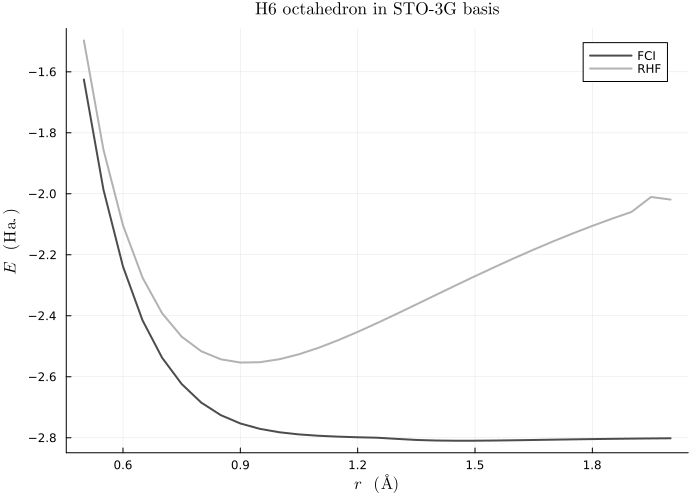

In [12]:
using LaTeXStrings

plt1 = plot(
    bond_lengths, 
    e_fci_vec, 
    color=RGB(0.3,0.3,0.3),
    linewidth=2.0,
    label="FCI",
    title="H6 octahedron in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    xguide=L"r\quad(\AA)",
    yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

plot!(
    bond_lengths, 
    e_rhf_vec, 
    color=RGB(0.7,0.7,0.7), 
    linewidth=2.0,
    label="RHF"
)

display(plt1)

#savefig("../plots/H6_Octahedron/RHF-to-FCI_comparison.pdf")
